In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle
from tensorflow import keras
from keras import layers, activations
import matplotlib

# Create Train test and validation set

In [2]:
def m2tex(model):
    stringlist = []
    model.summary(line_length=70, print_fn=lambda x: stringlist.append(x))
    del stringlist[1:-4:2]
    del stringlist[-1]
    for ix in range(1, len(stringlist)-3):
        tmp = stringlist[ix]
        stringlist[ix] = tmp[0:31]+"& "+tmp[31:59]+"& "+tmp[59:]+"\\\\"
    stringlist[0] = ''  # "Model: test \\\\ \hline"
    stringlist[1] = stringlist[1][:-8]+"eters # \\\\ \hline"
    stringlist[-5] = stringlist[-5]
    print(stringlist[1])

    prefix = ["\\begin{table}[]", "\\centering", "\\begin{tabular}{l|l|l}"]
    suffix = ["\end{tabular}", f"\caption{{Model has {stringlist[-3][14:].replace(',', '')} total parameters, \
of which {stringlist[-2][18:].replace(',', '')} are trainable. Optimizer is Adam and loss is Mean squared error.}}",
 "\label{tab:model-summary}", "\end{table}"]
    stringlist = stringlist[:-4]
    stringlist = prefix + stringlist + suffix
    out_str = " \n".join(stringlist)
    out_str = out_str.replace("_", "\_")
    out_str = out_str.replace("#", "\#")
    print(out_str)


In [59]:
model1 = keras.Sequential()
model1.add(layers.Input((2048, )))
model1.add(layers.Dense(512))
model1.add(layers.Activation(activations.sigmoid))
model1.add(layers.Dense(128))
model1.add(layers.Activation(activations.sigmoid))
model1.add(layers.Dense(512))
model1.add(layers.Activation(activations.sigmoid))
model1.add(layers.Dense(2048))
model1.build()
model1.summary()
m2tex(model1)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 512)               1049088   
                                                                 
 activation_4 (Activation)   (None, 512)               0         
                                                                 
 dense_17 (Dense)            (None, 128)               65664     
                                                                 
 activation_5 (Activation)   (None, 128)               0         
                                                                 
 dense_18 (Dense)            (None, 512)               66048     
                                                                 
 activation_6 (Activation)   (None, 512)               0         
                                                                 
 dense_19 (Dense)            (None, 2048)             

# Second network(Convolutional)

In [3]:
def model(sizes,kernel_size = [0,32]):
    model = 0
    model = keras.Sequential()
    model.add(layers.Input((2048, 1)))
    if kernel_size[0] ==0:
        
        model.add(layers.Conv1D(kernel_size=(kernel_size[1]), filters=1, padding="same"))
        model.add(layers.LeakyReLU(alpha=0.3))
    else:
        model.add(layers.Input((2048, 1)))
        model.add(layers.Conv1D(kernel_size=(kernel_size[0]), filters=1, padding="same"))
        model.add(layers.LeakyReLU(alpha=0.3))
        model.add(layers.Conv1D(kernel_size=(kernel_size[1]), filters=1, padding="same"))
        model.add(layers.LeakyReLU(alpha=0.3))

    model.add(layers.Reshape((2048,)))
    for size in sizes:
        model.add(layers.Dense(size))
        model.add(layers.LeakyReLU(alpha=0.3))
    model.add(layers.Dense(2048))
    model.build()
    return model

def generate_sizes(depth=48,skip=4):
    sizes = [2048]
    while sizes[-1]>depth:
        sizes.append(sizes[-1]/skip)
    sizes[-1] = depth
    sizes = sizes+sizes[-2::-1]
    return list(map(int, sizes))

k1 = (0, 256)
#k2 = (128, 256)

 
final_model = model(generate_sizes(),kernel_size=k1)
m2tex(final_model)

 Layer (type)                  & Output Shape                & Parameters # \\ \hline
\begin{table}[] 
\centering 
\begin{tabular}{l|l|l} 
 
 Layer (type)                  & Output Shape                & Parameters \# \\ \hline 
 conv1d (Conv1D)               & (None, 2048, 1)             & 257        \\ 
 leaky\_re\_lu (LeakyReLU)       & (None, 2048, 1)             & 0          \\ 
 reshape (Reshape)             & (None, 2048)                & 0          \\ 
 dense (Dense)                 & (None, 2048)                & 4196352    \\ 
 leaky\_re\_lu\_1 (LeakyReLU)     & (None, 2048)                & 0          \\ 
 dense\_1 (Dense)               & (None, 512)                 & 1049088    \\ 
 leaky\_re\_lu\_2 (LeakyReLU)     & (None, 512)                 & 0          \\ 
 dense\_2 (Dense)               & (None, 128)                 & 65664      \\ 
 leaky\_re\_lu\_3 (LeakyReLU)     & (None, 128)                 & 0          \\ 
 dense\_3 (Dense)               & (None, 48)            

In [2]:
def load_history(history_path,key = 'val_mean_squared_error'):
    with open(f'models/{history_path}/history', "rb") as file_pi:
        history = pickle.load(file_pi)
    if key:
        history = history[key]
    return history

def middle_mean(numbers):
    if np.isscalar(numbers):
        return numbers
    else:
        num = np.sort(np.array(numbers))
        return np.mean(num[1:-1])
def get_overfitting(path,best_epoch):
    val = load_history(f'{path}/30_model',key='val_mean_squared_error')
    train = load_history(f'{path}/30_model',key='mean_squared_error')
    if best_epoch>len(val)-3:
        best_epoch = best_epoch -3
    val_m = middle_mean(val[best_epoch-2:best_epoch+3])
    train_m = middle_mean(train[best_epoch-2:best_epoch+3])
    return val_m/train_m



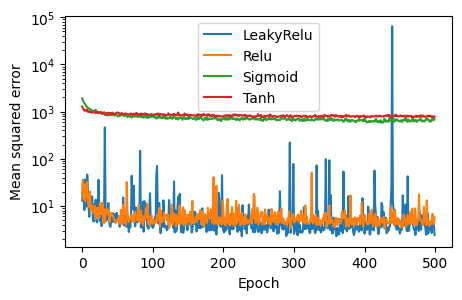

In [11]:
leakyRelu = load_history('1/1_leakyrelu/30_model')
relu = load_history('1/1_relu/30_model')
sigmoid = load_history('1/1_sigmoid/30_model')
tanh = load_history('1/1_tanh/30_model')

plt.figure(figsize=(5,3))

plt.plot(leakyRelu, label = 'LeakyRelu')
plt.plot(relu,label = 'Relu')
plt.plot(sigmoid,label= 'Sigmoid')
plt.plot(tanh,label = 'Tanh')
plt.yscale('log')
#plt.ylim(-100,2000)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Mean squared error')
#plt.savefig('plots/Activations.pdf',bbox_inches = 'tight')
plt.show()

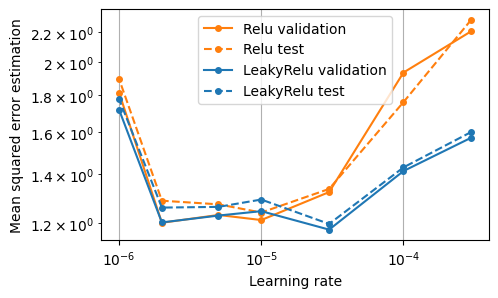

In [30]:
def get_numbers(paths,type):
    numbers = np.empty((len(paths),4))
    for counter, path in enumerate(paths):
        file = np.loadtxt(f'models/2/2_{type}_{path}/eval_numers.txt')[:-1]
        if path == 2e-06:
            file = np.loadtxt(f'models/2/x_{type}_{path}/eval_numers.txt')[:-1]
        numbers[counter] = file
        #numbers[counter,1]=path
        
    numbers[:, [0, 1]] = numbers[:, [1, 0]]
    return numbers.T

paths = [0.0003,0.0001,3e-05,1e-05,5e-06,2e-06,1e-06]#,5e-07,2e-07,1e-07,3e-08,1e-08]
r_numbers = get_numbers(paths, 'relu')
l_numbers = get_numbers(paths, 'leakyrelu')
#print(r_numbers,l_numbers)

plt.figure(figsize=(5,3))
plt.plot(paths,r_numbers[1],'o-',c = 'C1',ms=4,label='Relu validation')
plt.plot(paths,r_numbers[2],'o--',c = 'C1',ms=4,label='Relu test')
plt.plot(paths,l_numbers[1],'o-',c = 'C0',ms=4,label='LeakyRelu validation')
plt.plot(paths,l_numbers[2],'o--',c = 'C0',ms=4,label='LeakyRelu test')
plt.xlabel('Learning rate')
plt.ylabel('Mean squared error estimation')
plt.grid()
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.savefig('plots/LearingRate.pdf',bbox_inches = 'tight')
plt.show()



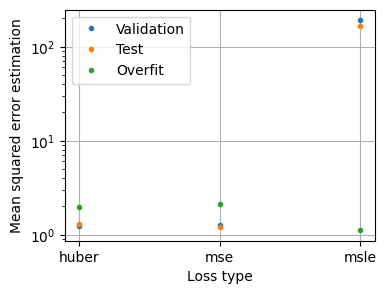

[[  1.97499344   1.22266917   1.2894206  643.        ]
 [  2.12549041   1.27536518   1.21500802 553.        ]
 [  1.11585344 190.36553196 165.44064331 980.        ]]


In [45]:
def get_numbers(paths):
    numbers = np.empty((len(paths),4))
    for counter, path in enumerate(paths):
        file = np.loadtxt(f'models/3/3_{path}/eval_numers.txt')[:-1]
        numbers[counter] = file
        numbers[counter,1]= get_overfitting(f'3/3_{path}',int(file[3]))
        
    numbers[:, [0, 1]] = numbers[:, [1, 0]]
    return numbers.T
names = ['huber','mse','msle']
losses = get_numbers(names)

plt.figure(figsize=(4,3))

plt.plot(losses[1],'o',ms=3,label='Validation')
plt.plot(losses[2],'o',ms=3,label='Test')
plt.plot(losses[0],'o',ms=3,label='Overfit')

plt.xlabel('Loss type')
plt.ylabel('Mean squared error estimation')
plt.grid()
plt.yscale('log')
plt.xticks([0,1,2],names)
plt.legend()
#plt.savefig('plots/Loss.pdf',bbox_inches = 'tight')
plt.show()
print(losses.T)

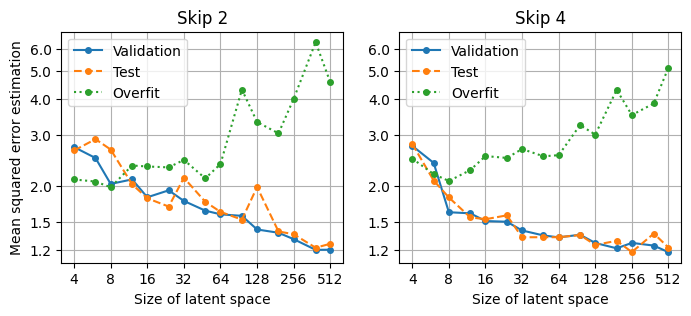

In [29]:
def get_numbers(depth,skip):
    numbers = np.empty((len(depth),4))
    for counter, depth in enumerate(depth):

        path = f'4/4_depth_{depth}_skip_{skip}'
        file = np.loadtxt(f'models/{path}/eval_numers.txt')[:-1]
        numbers[counter] = file
        numbers[counter,1]=get_overfitting(path,int(file[3]))

    numbers[:, [0, 1]] = numbers[:, [1, 0]]
    return numbers.T



depths =[4,6,8,12,16,24,32,48,64,96,128,192,256,388,512]
skip_2 = get_numbers(depths,2)
skip_4 = get_numbers(depths,4)

matplotlib.rcParams['xtick.minor.size'] = 0
matplotlib.rcParams['xtick.minor.width'] = 0

fig1, (ax1,ax2) = plt.subplots(1,2,figsize=(8,3),sharey=True)
ax1.plot(depths,skip_2[1],'o-',ms=4,label='Validation')
ax1.plot(depths,skip_2[2],'o--',ms=4,label='Test')
ax1.plot(depths,skip_2[0],'o:',ms=4,label='Overfit')
ax2.plot(depths,skip_4[1],'o-',ms=4,label='Validation')
ax2.plot(depths,skip_4[2],'o--',ms=4,label='Test')
ax2.plot(depths,skip_4[0],'o:',ms=4,label='Overfit')
ax1.set_title('Skip 2')
ax2.set_title('Skip 4')
ax1.set_ylabel('Mean squared error estimation')
ax2.yaxis.set_tick_params(labelbottom=True)

for ax in [ax1,ax2]:
    
    ax.set_xlabel('Size of latent space')
    ax.grid()

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xticks(depths[::2])
    ax.set_yticks([1.2,1.5,2,3,4,5,6])
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.legend()
plt.savefig('plots/Latentspace.pdf',bbox_inches = 'tight')
plt.show()

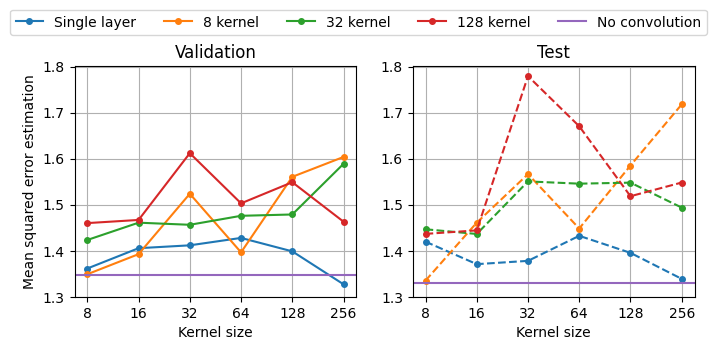

In [28]:
def get_numbers(first,second):
    numbers = np.empty((len(second),4))
    for counter, second in enumerate(second):

        path = f'5/5_first_{first}_second_{second}'
        file = np.loadtxt(f'models/{path}/eval_numers.txt')[:-1]
        numbers[counter] = file
        numbers[counter,1]=get_overfitting(path,int(file[3]))

    numbers[:, [0, 1]] = numbers[:, [1, 0]]
    return numbers.T
seconds =[8,16,32,64,128,256]
f0 = get_numbers(0,seconds)
f8 = get_numbers(8,seconds)
f32 = get_numbers(32,seconds)
f128 = get_numbers(128,seconds)

1.347632944458901472e+00
1.353410631418228149e+00
1.328938961029052734e+00


fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,3),sharey=True)
ax1.plot(seconds,f0[1],'o-',ms=4,label='Single layer')
ax1.plot(seconds,f8[1],'o-',ms=4,label='8 kernel')
ax1.plot(seconds,f32[1],'o-',ms=4,label='32 kernel')
ax1.plot(seconds,f128[1],'o-',ms=4,label='128 kernel')
ax1.axhline(y = 1.347632944458901472,c = 'C4',label = 'No convolution')
ax2.plot(seconds,f0[2],'o--',ms=4)#,label='Single layer')
ax2.plot(seconds,f8[2],'o--',ms=4)#,label='8 kernel before')
ax2.plot(seconds,f32[2],'o--',ms=4)#,label='32 kernel before')
ax2.plot(seconds,f128[2],'o--',ms=4)#,label='128 kernel before')

ax2.axhline(y = 1.328938961029052734,c = 'C4')#,label = 'Without convolution')


ax1.set_title('Validation')
ax2.set_title('Test')
ax1.set_ylabel('Mean squared error estimation')
ax2.yaxis.set_tick_params(labelbottom=True)

for ax in [ax1,ax2]:
    
    ax.set_xlabel('Kernel size')
    ax.grid()

    #ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xticks(seconds)
    ax.set_yticks([1.3,1.4,1.5,1.6,1.7,1.8])
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
fig.legend(bbox_to_anchor=(0.48,0.96), loc='lower center',ncol=5)
plt.savefig('plots/Convolution.pdf',bbox_inches = 'tight')
plt.show()


